In [1]:
from pandas import read_hdf

df = read_hdf("texts.hdf5", key="df", index_col=0)

In [38]:
cols = [col for col in df.columns.tolist()]
new_df = []

def get_batch(rows, n_lines: int = 10, min_size: int = 5):
    samples = len(rows)
    for batch_start in range(0, samples, n_lines):
        batch_end = min(batch_start+n_lines, samples)
        if not batch_end - batch_start  < min_size:
            yield "\n".join([row for row in rows[batch_start:batch_end]])
        
for (model, mss, page_id), group in df.sort_values("line_id").groupby(["model", "manuscript", "page_id"]):
    el = group.transcription.tolist()
    for batch_idx, line_batches in enumerate(get_batch(el)):
        new_df.append({
            "model": model,
            "lang": group.lang.values[0],
            "manuscript": mss,
            "page_id": page_id, 
            "line_id": batch_idx,
            "transcription": line_batches
        })
        
from pandas import DataFrame

df = DataFrame(new_df)

In [67]:
from nenequitia.metrics import computer_cer

GTs = {
    grp: row.iloc[0].transcription
    for grp, row in df[(df.model == "GT")].groupby(["manuscript", "page_id", "line_id"])
}

df["CER"] = .0

import tqdm
from fastwer import score_sent

for idx, row in tqdm.tqdm(df.iterrows()):
    df.at[idx, "CER"] = min(
        score_sent(row.transcription, GTs[(row.manuscript, row.page_id, row.line_id)], char_level=True),
        100
    )

32304it [00:12, 2691.06it/s]


<AxesSubplot:xlabel='manuscript', ylabel='CER'>

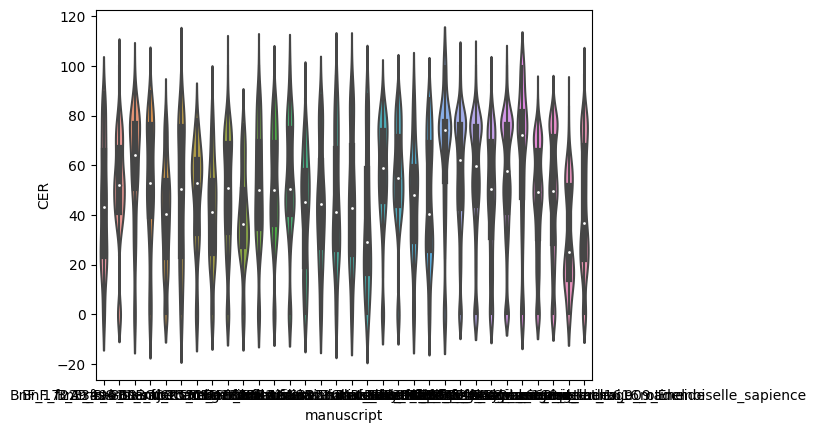

In [68]:
import seaborn as sns
sns.violinplot(data=df, x="manuscript", y="CER")

In [69]:
df.to_hdf("grouped_lines.hdf", key="df")